# DMD: Distribution Matching Distillation

One-step Diffusion with Distribution Matching Distillation, Yin et al., 2023. [[arXiv:2311.18828](https://arxiv.org/abs/2311.18828)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

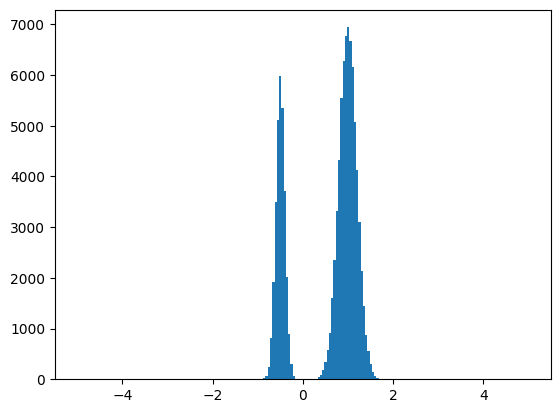

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Score Model

Define MLP backbone and score model first.

In [2]:
import torch
import torch.nn as nn

from flowmodels import VESDE, VESDEScheduler
from utils import Backbone


class OnestepSupports(Backbone):
    def forward(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor | None = None,
        label: torch.Tensor | None = None,
    ) -> torch.Tensor:
        if t is None:
            t = torch.ones(len(x_t))
        return super().forward(x_t, t, label)


COND = False
aux = 1 if not COND else 2
model = VESDE(OnestepSupports(aux=aux), VESDEScheduler())
model

VESDE(
  (score_estim): OnestepSupports(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Score Model

Train the score model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

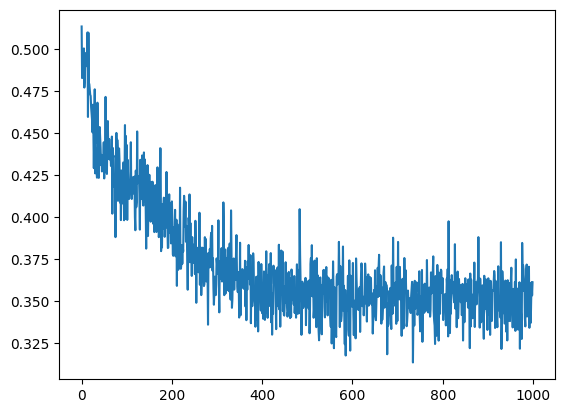

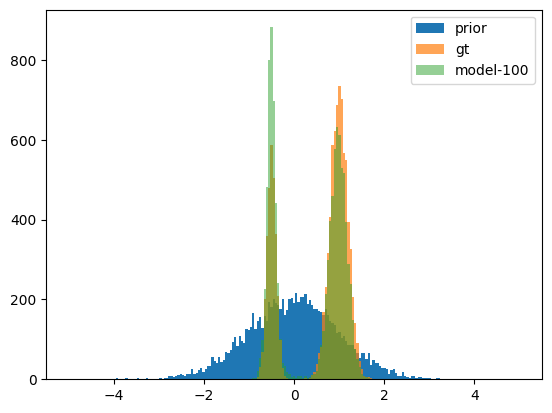

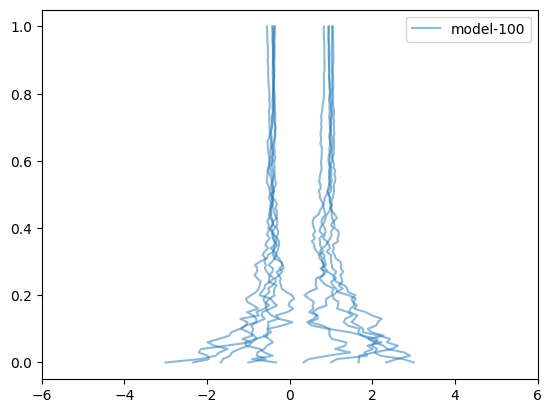

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indices],
            label=Y[indices] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[100])

## 4. Distribution Matching Distillation

Distill the knowledge of the pretrained score model to one-step generator

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

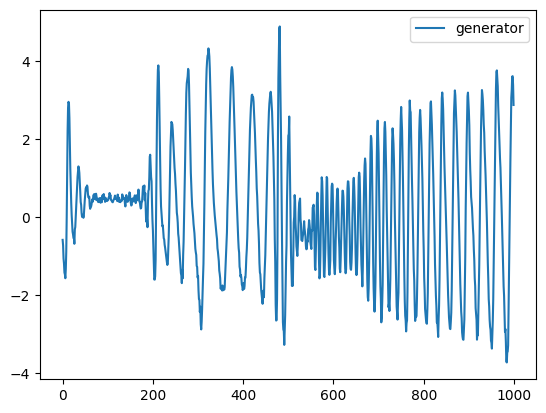

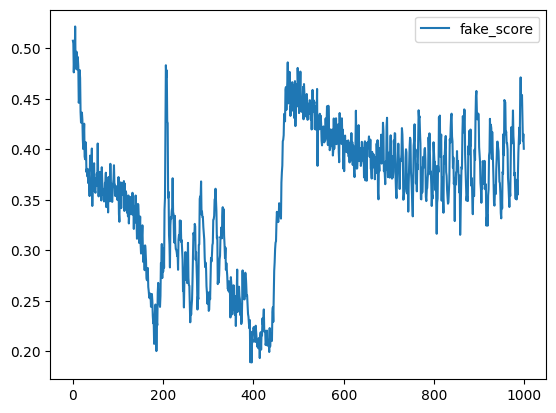

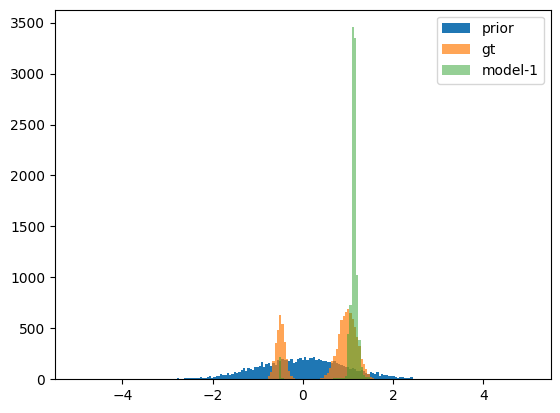

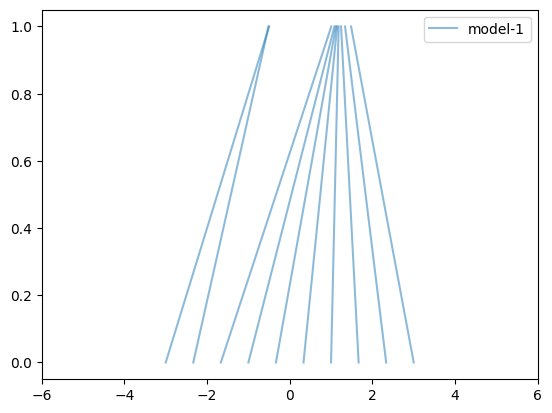

In [4]:
from flowmodels import DistributionMatchingDistillation

onestep = DistributionMatchingDistillation(
    OnestepSupports(aux=aux),
    VESDE(OnestepSupports(aux=aux), VESDEScheduler()),
)

# distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])
optim_g = torch.optim.Adam(onestep.generator.parameters(), LR)
optim_s = torch.optim.Adam(onestep.fake_score.parameters(), LR)
g_losses, s_losses = onestep.dmd(
    model,
    optim_g,
    optim_s,
    TRAIN_STEPS,
    BATCH_SIZE,
    prior,
    label=Y[torch.randperm(len(Y))[:n]] if COND else None,
    verbose=lambda r: tqdm(r, leave=False),
    _lambda=1.0,
)
plt.figure()
plt.plot(g_losses, label="generator")
plt.legend()

plt.figure()
plt.plot(s_losses, label="fake_score")
plt.legend()

vis(onestep, conditional=COND, steps=[1])

## 5. DMD2: Improved Distribution Matching Distillation for Fast Image Synthesis

Improved Distribution Matching Distillation for Fast Image Synthesis, Yin et al., 2024. [[arXiv:2405.14867](https://arxiv.org/abs/2405.14867)]

  0%|          | 0/1000 [00:00<?, ?it/s]

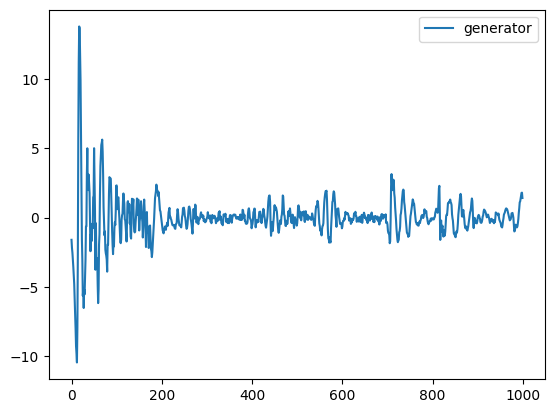

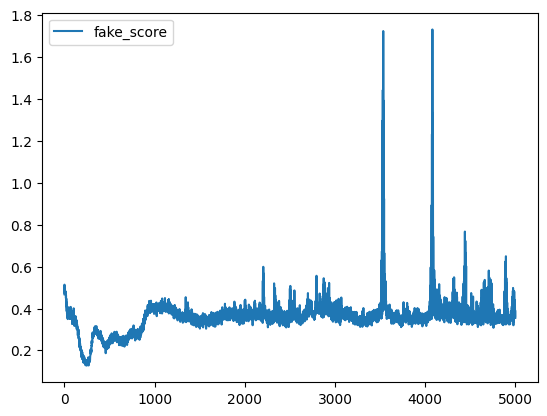

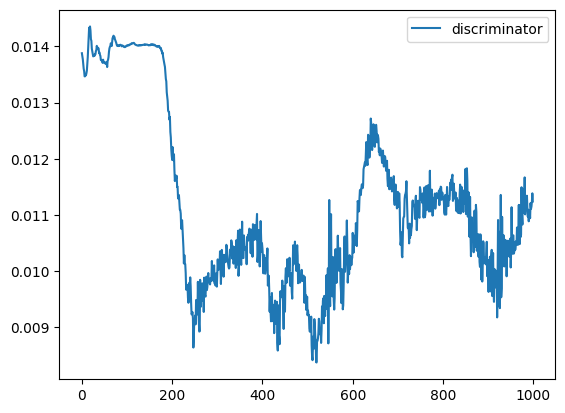

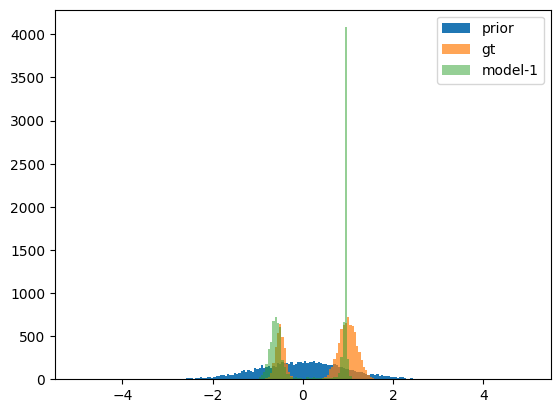

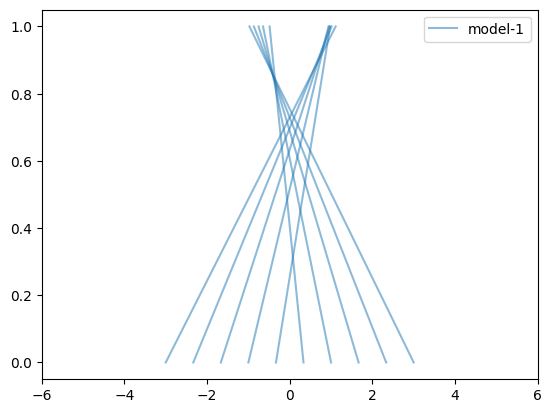

In [6]:
from flowmodels import DistributionMatchingDistillation


class _Discriminator(OnestepSupports):
    def __init__(self, backbone: nn.Module, branch_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            backbone,
            nn.Linear(branch_dim, branch_dim),
            nn.ReLU(),
            nn.Linear(branch_dim, branch_dim),
            nn.ReLU(),
            nn.Linear(branch_dim, 1),
        )


onestep = DistributionMatchingDistillation(
    OnestepSupports(aux=aux),
    VESDE(OnestepSupports(aux=aux), VESDEScheduler()),
)
discriminator = _Discriminator(onestep.fake_score.score_estim.net[:6])

# distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])
optim_g = torch.optim.Adam(onestep.generator.parameters(), LR)
optim_s = torch.optim.Adam(onestep.fake_score.parameters(), LR)
optim_d = torch.optim.Adam(discriminator.parameters(), LR)
g_losses, s_losses, d_losses = onestep.dmd2(
    model,
    discriminator,
    optim_g,
    optim_s,
    optim_d,
    TRAIN_STEPS,
    BATCH_SIZE,
    X,
    prior,
    label=Y[torch.randperm(len(Y))[:n]] if COND else None,
    # h="jensen-shannon",
    verbose=lambda r: tqdm(r, leave=False),
)
plt.figure()
plt.plot(g_losses, label="generator")
plt.legend()

plt.figure()
plt.plot(s_losses, label="fake_score")
plt.legend()

plt.figure()
plt.plot(d_losses, label="discriminator")
plt.legend()
vis(onestep, conditional=COND, steps=[1])